# Image Classification: EuroSAT Land Use and Land Cover Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lukas-gysin/bverl-miniproject/blob/main/notebooks/00-submission.ipynb)

Submission of the group **GeoGuesser**
by Julian Steinacher and Lukas Gysin

In [1]:
%%capture
%pip install lightning torchinfo torchshow

In [100]:
# Python Standard Library
import os

# Third Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision.transforms import functional as tvF
from torchvision.transforms import Normalize

In [3]:
# Import geoguesser library
try:
  import geoguesser
  print("package installed, all good")
except ImportError as e:
  print("Installing from git repo")
  os.system("pip install git+https://github.com/lukas-gysin/bverl-miniproject")

from geoguesser.classifier import Classifier
from geoguesser.dataset import EuroSATDataset
from geoguesser.dataset import EuroSATDataLoader
from geoguesser.trainer import Trainer

Installing from git repo


In [98]:
# Global Configuration
seed = 1234

sns.set_theme()

## Introduction

## Data

In [43]:
# Python Standard Library
import os
from pathlib import Path
import requests
from typing import Callable
from typing import Literal
import zipfile

# Third Party Libraries
from PIL import Image
from sklearn.model_selection import train_test_split
import tifffile
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms


class EuroSATDataset(Dataset):
  def __init__(self, root_dir, transform: Callable | None = None,):
    self.root_dir = root_dir
    self.transform = transform

    self.observations = list()
    self.classes = os.listdir(root_dir)
    for label in self.classes:
        class_dir = os.path.join(root_dir, label)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if any(img_path.lower().endswith(ext) for ext in ['.jpg', '.tif']):
                self.observations.append({"image_path": img_path, "label": label})

  def __len__(self):
    return len(self.observations)

  def __getitem__(self, idx):
    image_path = self.observations[idx]["image_path"]
    _ , ext = os.path.splitext(image_path)
    if ext == '.jpg':
      image = Image.open(image_path)
      image = transforms.ToTensor()(image)
    else:
      image = tifffile.imread(image_path)
      image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

    label = self.observations[idx]["label"]
    label_num = self.classes.index(label)

    if self.transform:
      image = self.transform(image)

    file, _ = os.path.splitext(os.path.basename(image_path))
    return {"image": image, "label": label_num, "file": file}

  def get(self, filename: str):
    for idx, observation in enumerate(self.observations):
      file, ext = os.path.splitext(os.path.basename(observation['image_path']))
      if file == filename:
        return self.__getitem__(idx)
    raise ValueError(f"Observation with filename {filename} not found in the dataset.")

  @classmethod
  def download(cls, dataset: Literal['RGB', 'MS'] = 'MS', download_dir: Path = Path('/workspace/code/data')):
    if dataset == 'RGB':
      url = 'https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1'
    else:
      # Multi-spectral dataset selected
      url = 'https://zenodo.org/records/7711810/files/EuroSAT_MS.zip?download=1'

    save_path = download_dir / f'{dataset}.zip'
    extract_path = download_dir / f'{dataset}/'

    os.makedirs(download_dir, exist_ok=True)

    if save_path.exists():
      # Zip file already downloaded and saved on local machine
      print(f"Dataset already saved in {save_path} - not overwriting")
    else:
      # Zip file is not downloaded yet
      print(f"Starting download from {url}")
      response = requests.get(url, allow_redirects=True)
      with open(save_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
          file.write(chunk)
      print(f"Dataset downloaded and saved to {save_path}")

    if extract_path.exists():
      # Zip file already extracted to local storage
      print(f"Dataset already extracted to {extract_path} - not overwriting")
    else:
      # Zip file not extracted yet
      print(f"Starting extracting dataset to {extract_path}")
      with zipfile.ZipFile(save_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
      print(f"Dataset extracted to {extract_path}")

    if dataset == 'RGB':
      return cls(root_dir=extract_path / 'EuroSAT_RGB/')
    # Else: Multi-spectral dataset selected
    return cls(root_dir=extract_path / 'EuroSAT_MS/')

  @classmethod
  def from_subset(cls, original, indices: list[int], transform: Callable | None = None):
      # Create a new instance with the same properties as the original
      subset = cls(root_dir=original.root_dir, transform=original.transform if transform is None else transform,)

      # Filter the observations based on the subset indices
      subset.observations = [original.observations[i] for i in indices]
      subset.classes = original.classes  # Keep class list consistent

      print(f'Created a subset with {len(subset.observations):_} of {len(original.observations):_} images')

      return subset

class EuroSATDataLoader:
  def __init__(self, dataset: EuroSATDataset, seed):
    self.dataset = dataset

    ids = [idx for idx in range(0, len(dataset.observations))]
    labels = [observation["label"] for observation in dataset.observations]

    self.train_ids, self.test_ids = train_test_split(ids, train_size=0.8,  random_state=seed, stratify=labels)
    self.val_ids, self.test_ids = train_test_split(self.test_ids, train_size=0.5,  random_state=seed, stratify=[labels[i] for i in self.test_ids])

  def testing(self, transformer: Callable | None = None):
    dataset_test = EuroSATDataset.from_subset(self.dataset, self.test_ids, transform=transformer)
    return DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=os.cpu_count())

  def training(self, transformer: Callable | None = None):
    dataset_train = EuroSATDataset.from_subset(self.dataset, self.train_ids, transform=transformer)
    return DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=os.cpu_count())

  def validation(self, transformer: Callable | None = None):
    dataset_val = EuroSATDataset.from_subset(self.dataset, self.val_ids, transform=transformer)
    return DataLoader(dataset_val, batch_size=16, shuffle=False, num_workers=os.cpu_count())

In [115]:
dataset_ms = EuroSATDataset.download(dataset='MS')
dataset_rgb = EuroSATDataset.download(dataset='RGB')

# Normalize MS Dataset, since some channels have realy big values
values = {}
for channel in range(dataset_ms[0]['image'].size(0)):
  values[channel] = []

for idx in range(min(len(dataset_ms), 1_000)):
  observation = dataset_ms[idx]
  for channel in range(observation['image'].size(0)):
    values[channel].append(observation['image'][channel].mean())

means = []
stds = []
for channel in range(dataset_ms[0]['image'].size(0)):
  means.append(np.mean(values[channel]))
  stds.append(np.std(values[channel]))

ids = [i for i in range(len(dataset_ms))]
dataset_ms = EuroSATDataset.from_subset(dataset_ms, ids, transform=Normalize(mean=means, std=stds))

Dataset already saved in /workspace/code/data/MS.zip - not overwriting
Dataset already extracted to /workspace/code/data/MS - not overwriting
Dataset already saved in /workspace/code/data/RGB.zip - not overwriting
Dataset already extracted to /workspace/code/data/RGB - not overwriting
Created a subset with 27_000 of 27_000 images


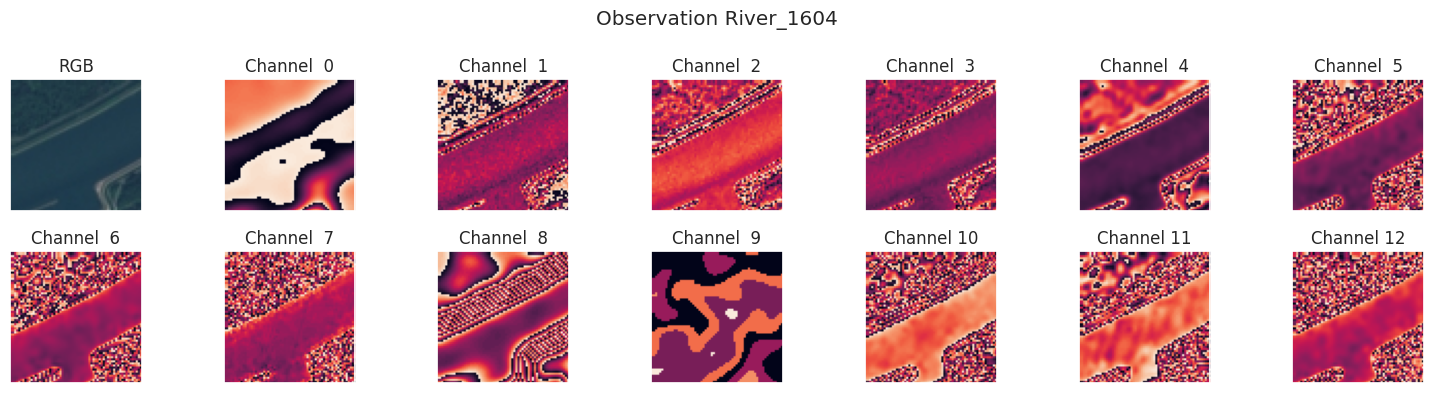

In [116]:
fig, axs = plt.subplots(figsize=(16, 4), ncols=7, nrows=2, layout='tight')
axs = axs.flatten()

observation_ms = dataset_ms[17_000]
observation_rgb = dataset_rgb.get(observation_ms['file'])

fig.suptitle(f'Observation {observation_rgb["file"]}')

axs[0].imshow(tvF.to_pil_image(pic=observation_rgb['image']))
_ = axs[0].set_title(f'RGB')
_ = axs[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

for channel in range(observation_ms['image'].size(0)):
  axs[channel+1].imshow(tvF.to_pil_image(pic=observation_ms['image'][channel]))
  _ = axs[channel+1].set_title(f'Channel {channel:2}')
  _ = axs[channel+1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


The data consists of 27000 datasets containing a label, a RGB Image and a TIF image containing additional 13 Channels. The images are made from a satellite. These datasets are can be found separated on zenodo. They are already delivered in a folder structure where every image is in a folder for their label. Each image has a resolution of 64 by 64. However some channels of the tif image are upsampled to get to this resolution. Each pixel covers 10 meters of land.

The images are divided into 10 labels with each label having at least 2000 datasets:
*  'SeaLake' => 3000 sets
* 'Pasture' => 2000 sets
*  'River' => 2500 sets
* 'PermanentCrop' => 2500 sets
*  'Residential' => 3000 sets
*  'Industrial' => 2500 sets
*  'HerbaceousVegetation' => 3000sets
* 'AnnualCrop' => 3000 sets
* 'Highway' => 2500 sets
* 'Forest' => 3000 sets



<ipython-input-111-eb1ea5be9734>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels, rotation=15, ha='right')


[Text(0, 0, 'AnnualCrop'),
 Text(1, 0, 'Forest'),
 Text(2, 0, 'HerbaceousVegetation'),
 Text(3, 0, 'Highway'),
 Text(4, 0, 'Industrial'),
 Text(5, 0, 'Pasture'),
 Text(6, 0, 'PermanentCrop'),
 Text(7, 0, 'Residential'),
 Text(8, 0, 'River'),
 Text(9, 0, 'SeaLake')]

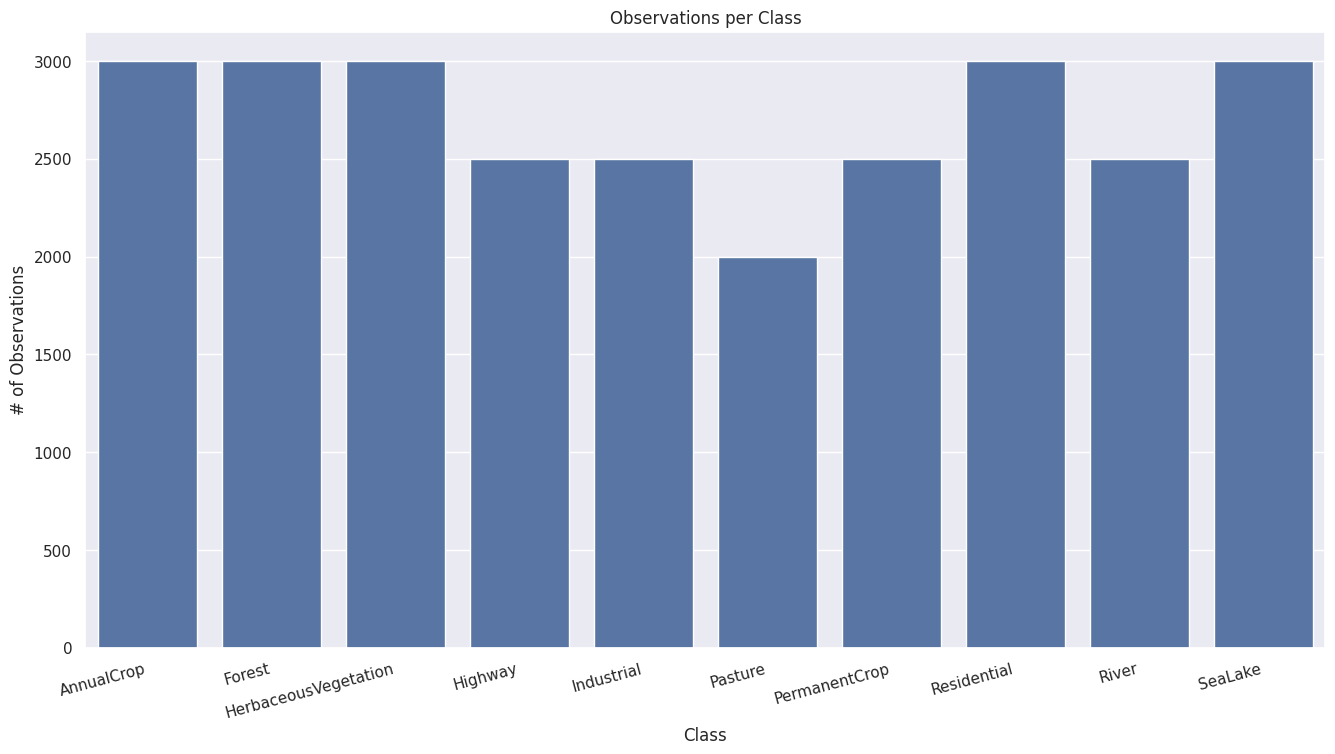

In [111]:
labels = [x["label"] for x in dataset_rgb.observations]

label_order = list(set(labels))
label_order.sort()

labels_count = {}
for label in labels:
  if label in labels_count:
    labels_count[label] += 1
  else:
    labels_count[label] = 1

fig, ax = plt.subplots(figsize=(16, 8))

ax = sns.barplot(data=labels_count, order=label_order, errorbar=None, ax=ax)
ax.set_title("Observations per Class")
ax.set_xlabel("Class")
ax.set_ylabel("# of Observations")
tick_labels = ax.get_xticklabels()
ax.set_xticklabels(tick_labels, rotation=15, ha='right')

## Models

## Results

## Discussion